In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocesing

In [2]:
path = "D:\\Programowanie\\R\\WdAD\\WdAD_projekt_wikipedia-main\\data\\"

maths = pd.read_csv(path+"mathematics_d2.csv",index_col=0)
physics = pd.read_csv(path+"physics_d2.csv", index_col=0)
history = pd.read_csv(path+"history_d2.csv", index_col=0)

In [3]:
maths["type"] = "mathematics"
physics["type"] = "physics"
history["type"] = "history"

In [4]:
df = pd.concat([maths,physics, history], ignore_index=True)
len(df)

29924

## Połączenie duplikatów (artykuły będące w kategoriach z dwóch typów)

In [5]:
duplikaty = df[df.duplicated(["title"], keep=False)].sort_values(by="title")

print(len(duplikaty))

duplikaty_merged = duplikaty.groupby('title', as_index=False).first()

types = duplikaty.groupby('title')['type'].apply(lambda x: ', '.join(sorted(set(x)))).reset_index()

duplikaty_merged['type'] = types['type']

print(duplikaty_merged['type'].value_counts())

zduplikowane_tytuły = duplikaty_merged["title"]
df = df[~df["title"].isin(zduplikowane_tytuły)]

df = pd.concat([df, duplikaty_merged], ignore_index=True)

print(len(df))

1068
type
mathematics, physics    492
history, mathematics     25
history, physics         17
Name: count, dtype: int64
29390


## Zamian wszystkich słów na małe znaki

In [6]:
text_cols = df.select_dtypes(include=["object"]).columns

for i in text_cols:
  df[i] = df[i].str.lower()

## Zamiana "categories" oraz "images_titles" na słowa oddzielone przecinkami

In [7]:
df["categories"] = (
  df["categories"]
  .str.replace("['category:", "")
  .str.replace("']","")
  .str.split("', 'category:")
  #.apply(lambda x: ", ".join(x))
)

df["image_titles"] = (df["image_titles"]
 .str.replace("['file:", "")
 .str.replace("']","")
 .str.replace("[]", "") #dla pustych list
 .str.split("', 'file:")
 #.apply(lambda x: ", ".join(x))
)

df["categories_string"] = df["categories"].apply(lambda x: ", ".join(x))
df["image_titles_string"] = df["image_titles"].apply(lambda x: ", ".join(x))

In [8]:
df["creation_date_timestamp"] = pd.to_datetime(df.creation_date, utc=True).astype(int) //10**9
df["links_per_word"] = df.num_links_internal // df.word_count

In [9]:
categories_uniques = list(set([item for sublist in df["categories"] for item in sublist]))
print(len(categories_uniques))

68749


# Exploratory Analyses

## Usunięcie artykułów o zerowej długości 

In [10]:
print(len(df[df["word_count"]==0]))

df = df[df["word_count"]>0]

616


## Artykuły z większą ilością linków niż słów 

In [11]:
print(len(df[df["word_count"]<df["num_links_internal"]]))

df[df["word_count"]<df["num_links_internal"]].head()

1572


,title,word_count,num_links_internal,num_categories,categories,num_images,image_titles,num_edits,num_editors,summary,creation_date,mo_page_views,clicks_in,clicks_out,clicks_per_view,type,categories_string,image_titles_string,creation_date_timestamp,links_per_word
43,société mathématique de france,106,181,6,"[1872 establishments in france, articles with ...",3,"[logosmf.gif, maison de la smf.jpg, oojs ui ic...",51,39,the société mathématique de france (smf) is th...,2005-04-04t11:24:18z,364,65,12,0.032967,mathematics,"1872 establishments in france, articles with s...","logosmf.gif, maison de la smf.jpg, oojs ui ico...",1112613858,1.0
158,lokavibhaga,390,430,16,"[458, 5th-century books, 5th century in india,...",7,"[045r b.jpg, flag of india.svg, in-jain-o.svg,...",64,44,"the lokavibhāga (literally ""division of the un...",2008-12-06t00:18:15z,478,51,0,0.000000,mathematics,"458, 5th-century books, 5th century in india, ...","045r b.jpg, flag of india.svg, in-jain-o.svg, ...",1228522695,1.0
164,mazhamaṅgalaṃ śaṅkaran naṃpūtiri,235,289,9,"[articles with short description, astronomy in...",0,[],10,6,mazhamaṅgalaṃ śaṅkaran naṃpūtiri (śaṅkara of m...,2023-12-04t14:30:04z,103,0,0,0.000000,mathematics,"articles with short description, astronomy in ...",,1701700204,1.0
208,list of mathematical theories,7,90,4,"[articles with short description, fields of ma...",0,[],116,64,this is a list of mathematical theories.,2004-05-25t10:30:08z,2919,2488,2426,0.831107,mathematics,"articles with short description, fields of mat...",,1085481008,12.0
304,trapping region,105,112,7,"[all articles needing additional references, a...",5,"[commons-logo.svg, e-to-the-i-pi.svg, question...",12,8,"in applied mathematics, a trapping region of a...",2011-06-10t06:17:06z,127,34,0,0.000000,mathematics,"all articles needing additional references, al...","commons-logo.svg, e-to-the-i-pi.svg, question ...",1307686626,1.0


Z czego co sprawdzałem są to głównie artykuły będące listami zbiorczymi, ale także krótkie artykuły z długą listą linków. Świadczy to o tym, że linki są liczone osobno niż słowa, co więcej (sprawdzone empirycznie) link składający się z kilku słów jest liczony jako jeden. Ponadto linki nie pojawiają się w summary. Należy brać to pod uwagę w dalszej analizie, w skrajnych przypadkach (jak chociażby artykuły będące listami), będzie to miało dość spore znaczenie. Niemnniej jednak, nie usuwam tych danych, jako iż noszą treść.

## Usunięcie `Clicks_per_view` większych od 1 (i sprawdzenie, czy nie ma ujemnych)

Jako iż `Clicks_per_view` jest ilorazem `clicks_out`/`mo_page_views`, to nie powinien wynosić więcej niż 1 (gdyż nie powinno być więcej kliknięć w linki na stronie niż wyświetleń). Dlatego odrzucamy wszystko co powyżej

In [12]:
print(len(df[df["clicks_per_view"]>1]))
print(len(df[df["clicks_per_view"]<0]))

df = df[df["clicks_per_view"]<=1]

147
0


## Wizualizacja rozkładów poszczególnych zmiennych

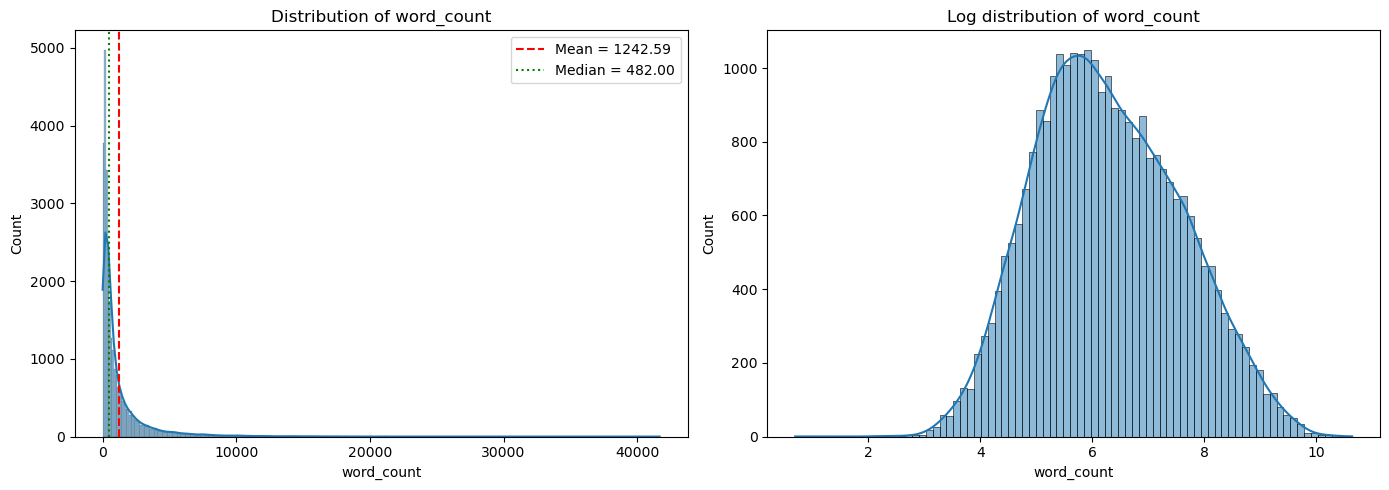

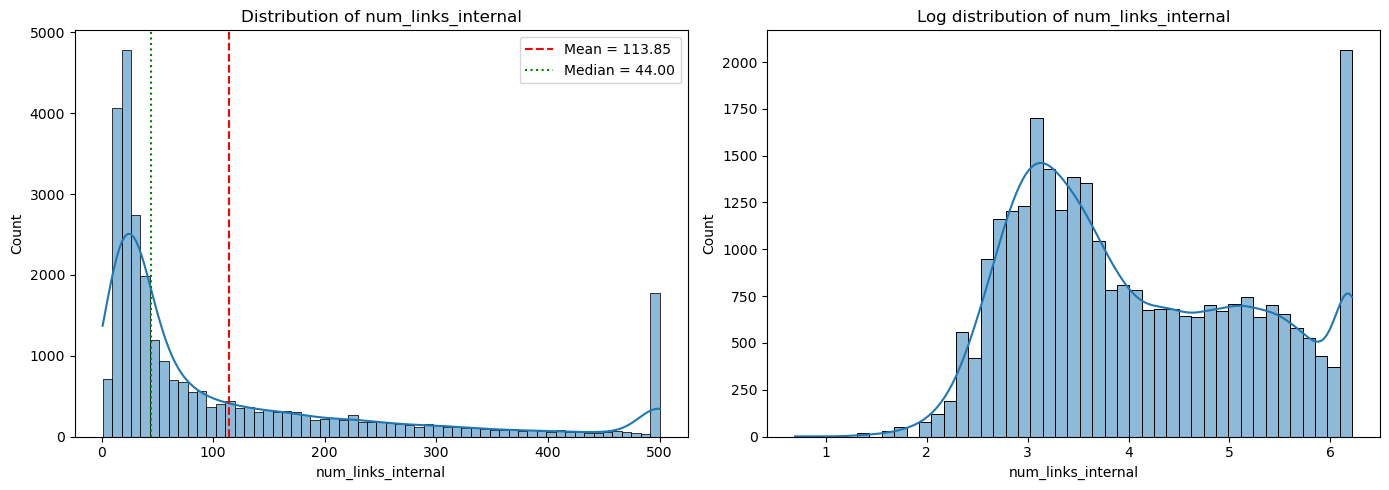

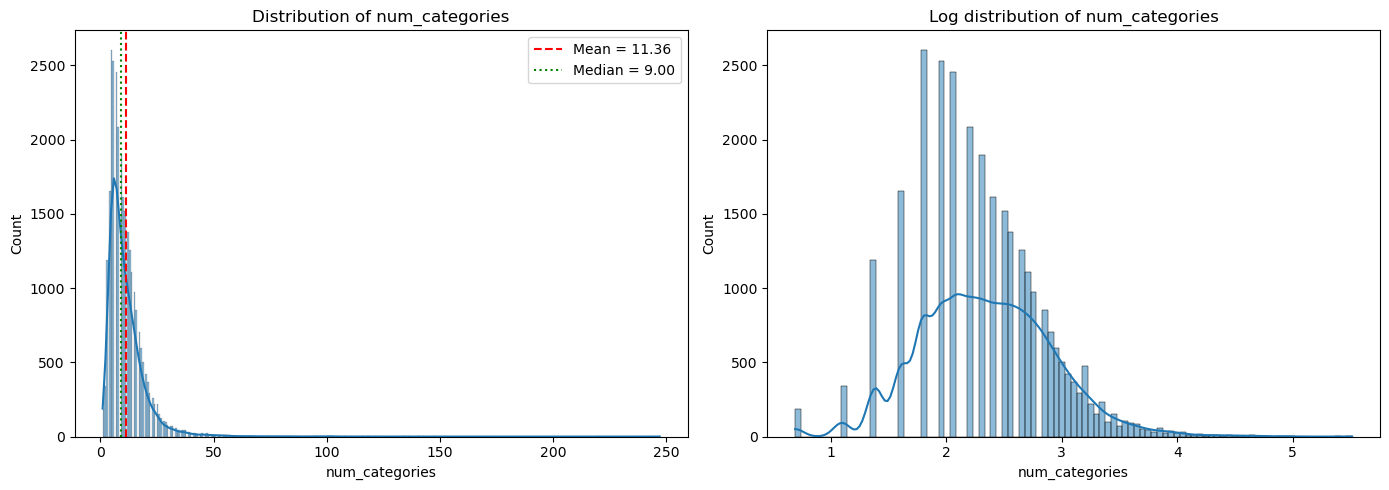

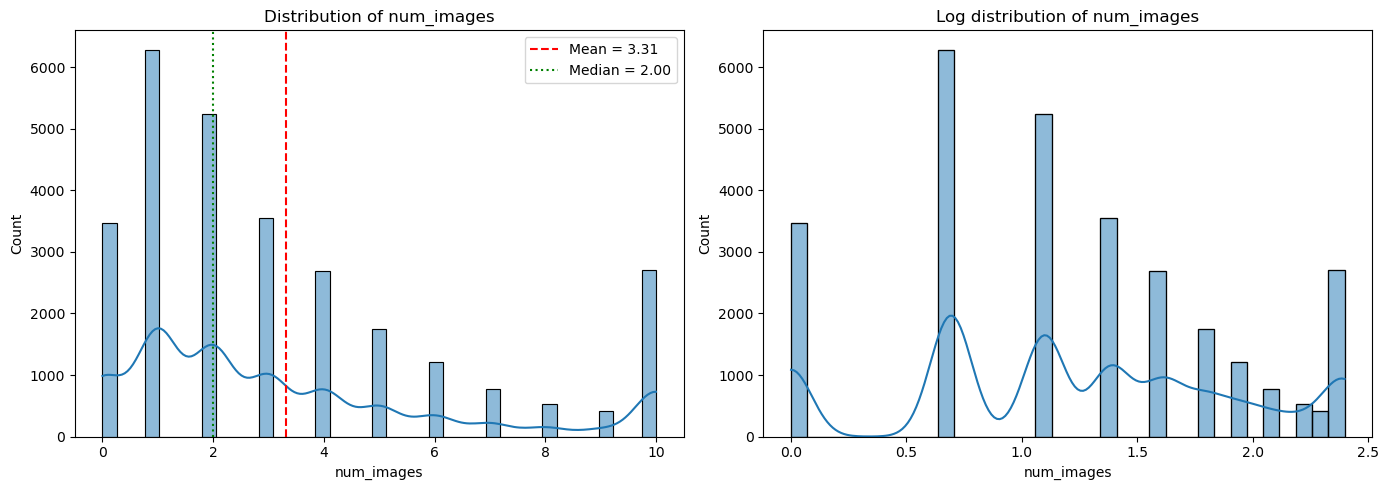

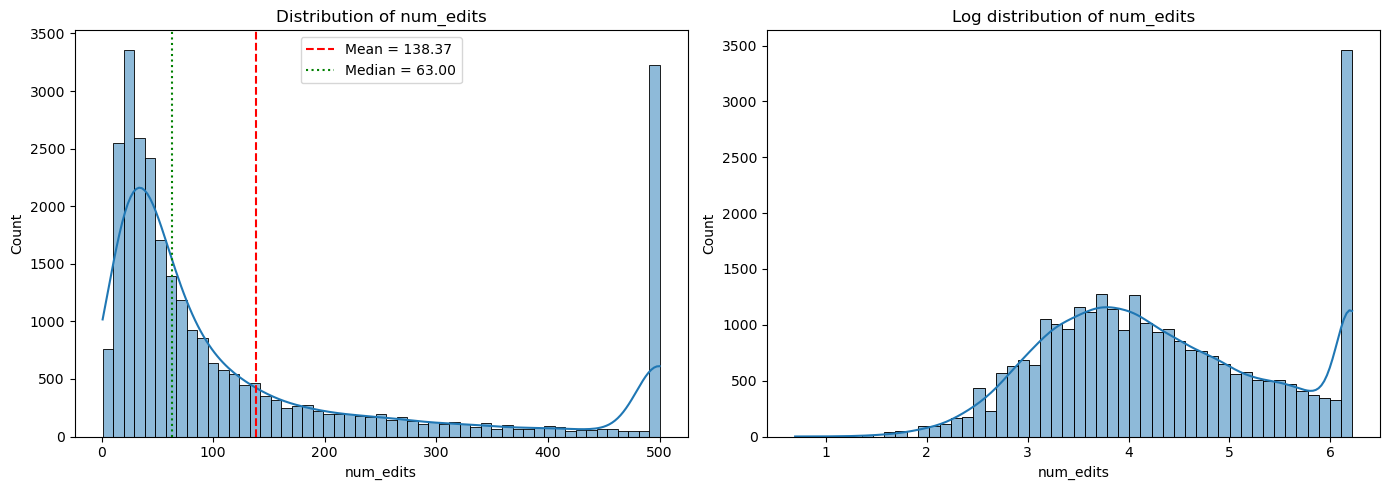

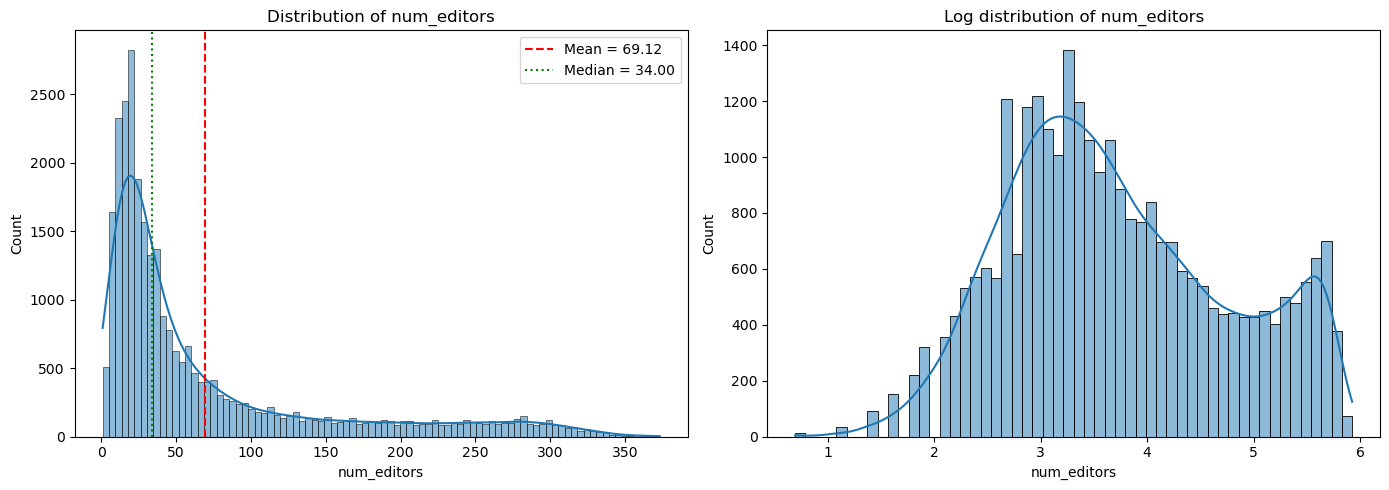

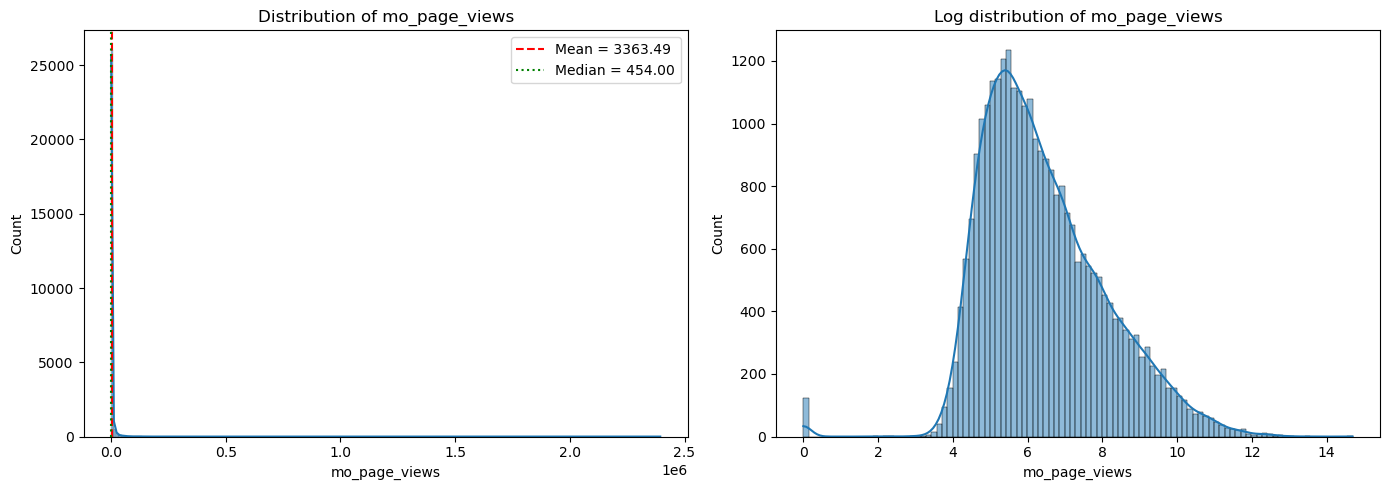

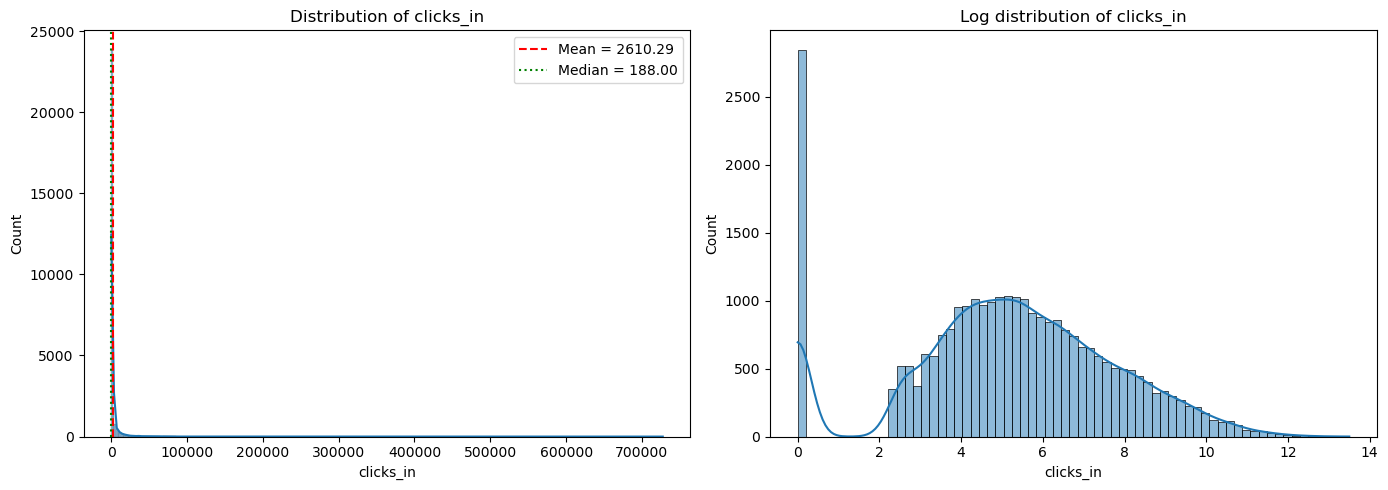

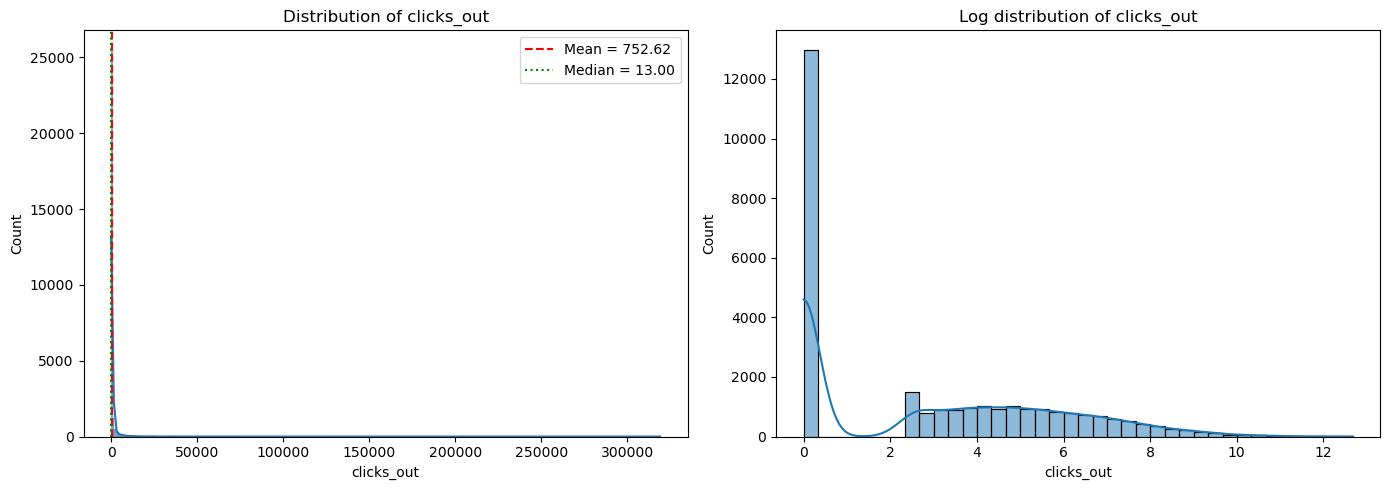

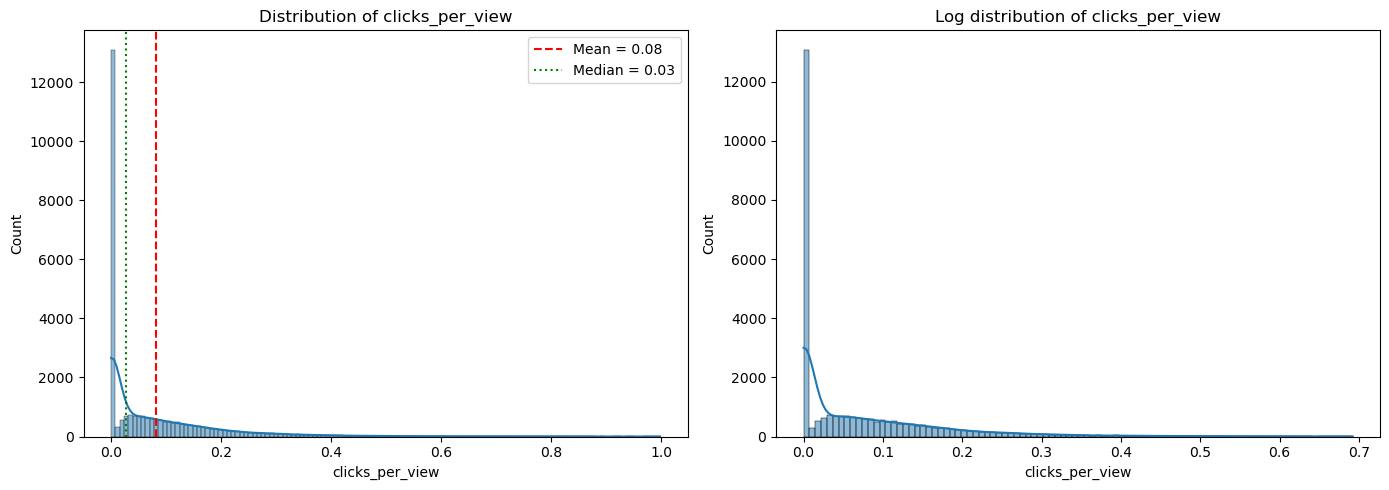

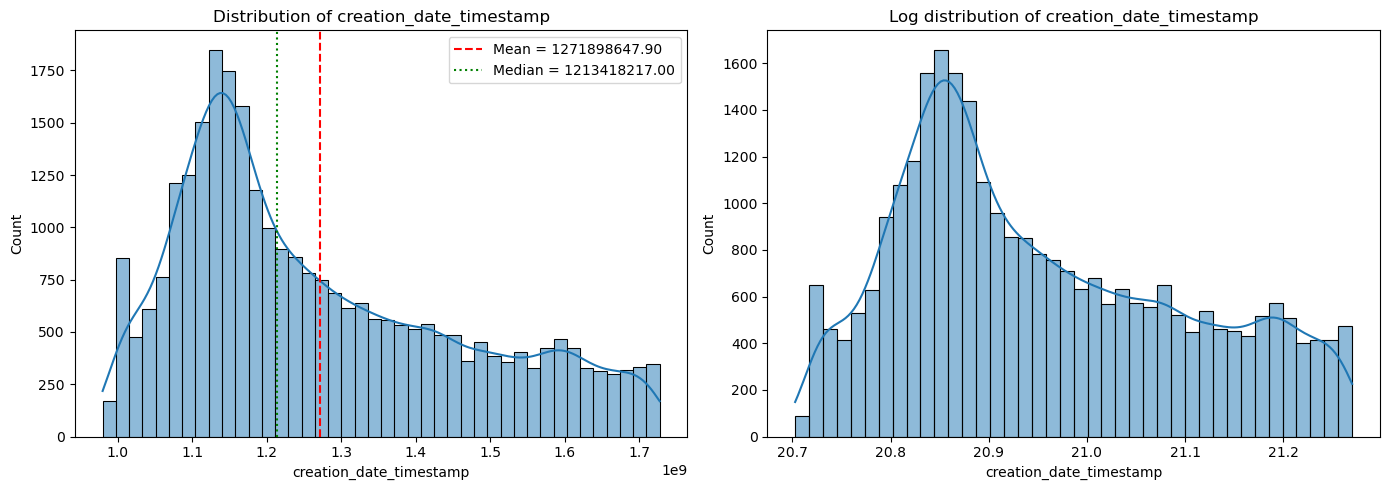

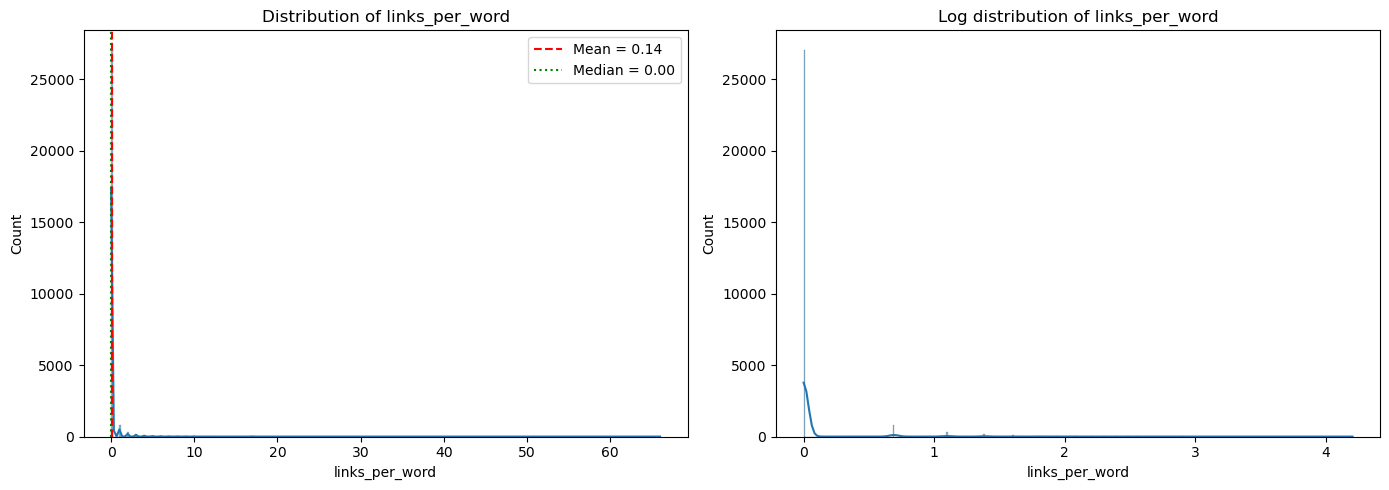

In [13]:
for col in df.select_dtypes(include=["number"]).columns:
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))  

    sns.histplot(df[col], kde=True, ax=axes[0])
    axes[0].set_title(f"Distribution of {col}")
    mean_val = df[col].mean()
    median_val = df[col].median()
    axes[0].axvline(mean_val, color="red", linestyle="--", label=f"Mean = {mean_val:.2f}")
    axes[0].axvline(median_val, color="green", linestyle=":", label=f"Median = {median_val:.2f}")
    axes[0].legend()


    positive_values = df[df[col]+1 > 0][col]
    sns.histplot(np.log(positive_values+1), kde=True, ax=axes[1])
    axes[1].set_title(f"Log distribution of {col}")

    plt.tight_layout()
    plt.show()

Wykresy pokazują, że większość zmiennych ma rozkład mocno prawoskośny. Jak widać, zlogarytmowanie w większości przypadków tworzy względnie symetryczne rozkłady. Niepokojące jest to, że `num_links_internal` oraz `num_edits` mają zdecydowanie podwyższone ilości skrajnych wartości (tj 500), co może świadczyć o tym, że albo wyższe ilości linków oraz edycji zostały zapisane jako 500, albo jest to limit linków i edycji na stronie. Należy to wziąć pod uwagę w dalszych krokach. Również takie cechy przejawia `num_images`, gdzie tym limitem może być 10 zdjęć na stronę. Należy też zauważyć, że `mo_page_views`, `clicks_in`, `clicks_out` oraz w szczególności `clicks_per_view`, mają znaczące ilości 0 wartości. W każdym razie warto będzie uwzględnić zlogarytmowane zmienne w zbiorze danych.

In [14]:
for col in df.select_dtypes(include=["number"]).columns:
  df[f"log_{col}"] = np.log1p(df[col])

## Analiza Kowariancji

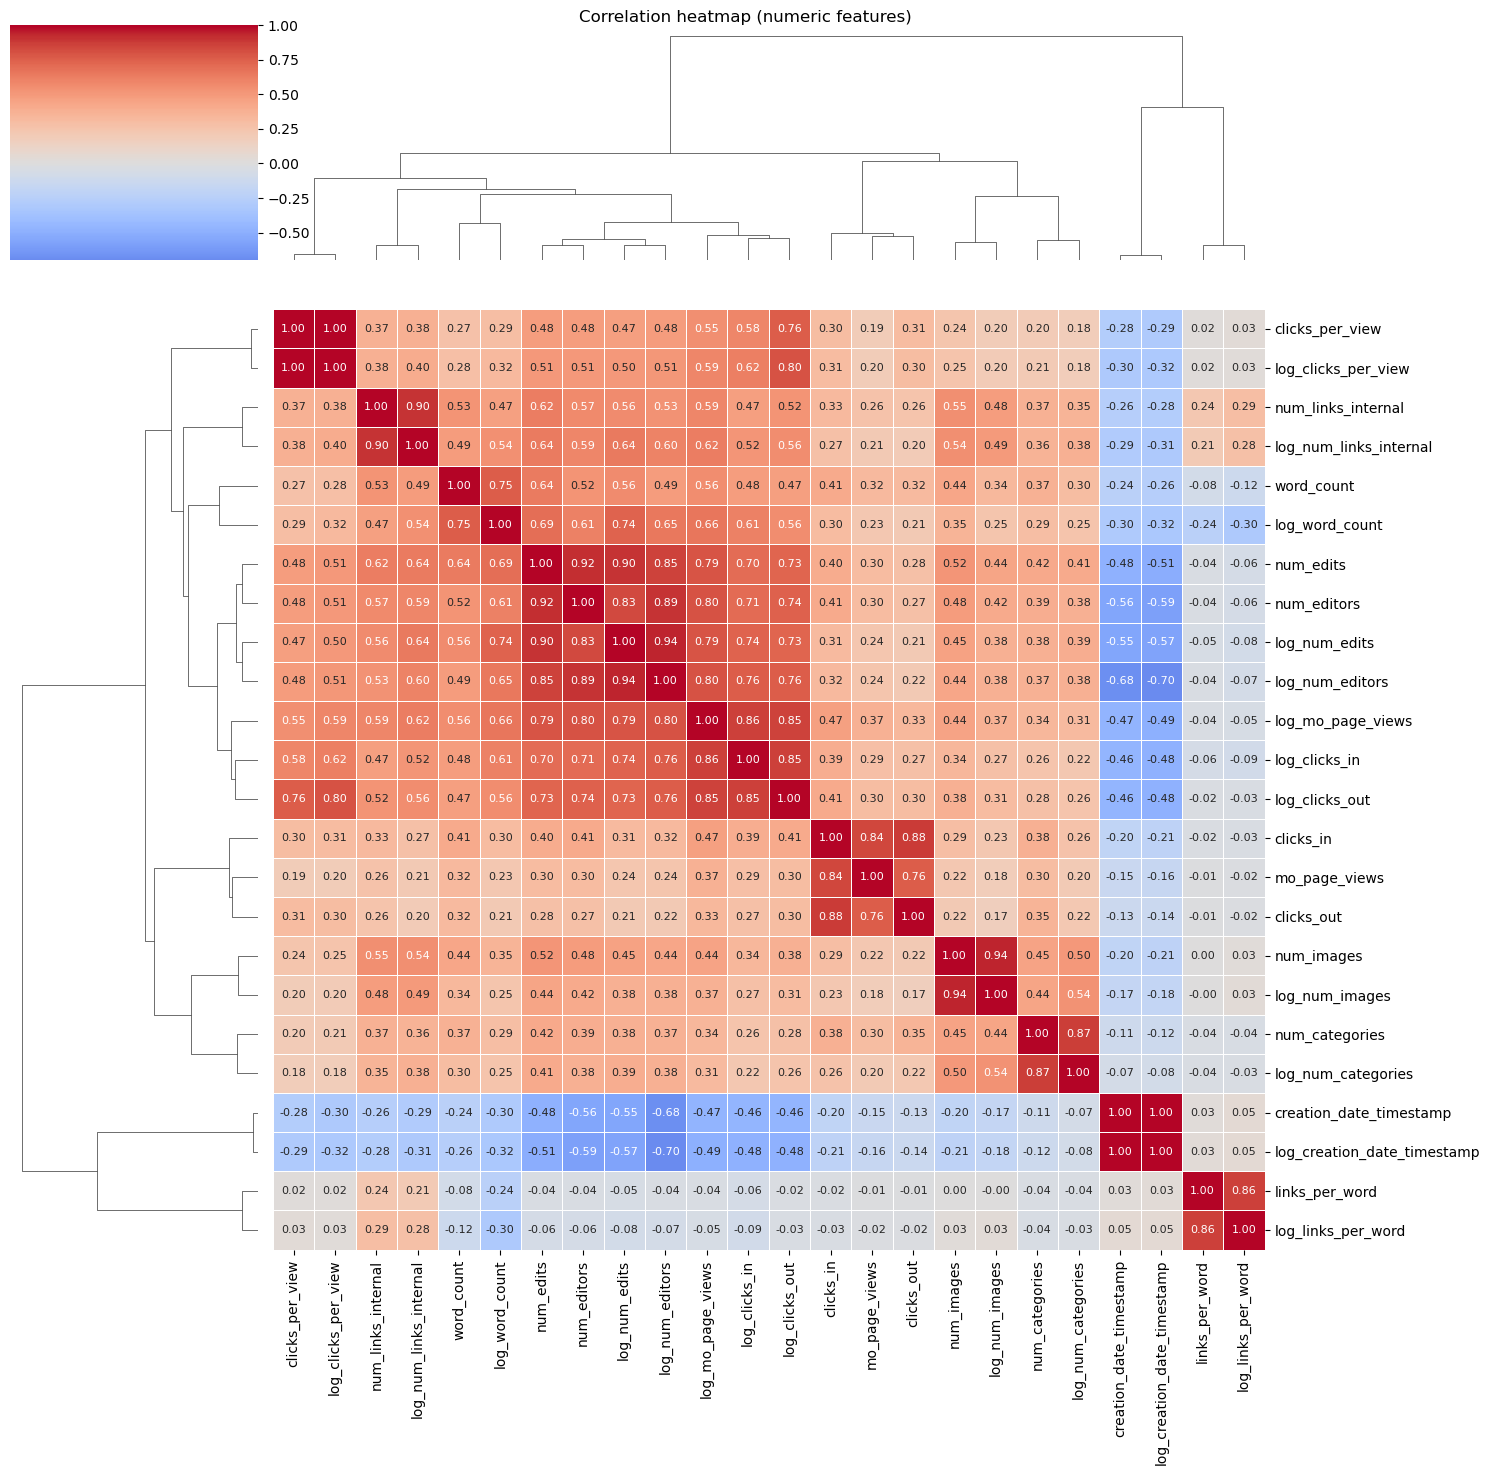

In [21]:
num_cols = df.select_dtypes(include=["number"]).columns

df_corr = df[num_cols].copy()
df_corr = df_corr.astype(float)

corr = df_corr.corr()

#plt.figure(figsize=(15, 8))
g = sns.clustermap(
    corr,
    annot=True,
    cmap="coolwarm",
    center=0,
    fmt=".2f",
    linewidths=0.5,
    figsize=(15, 15), 
    annot_kws={"size": 8}
)

g.fig.suptitle("Correlation heatmap (numeric features)")
plt.tight_layout()
plt.show()

Umieszczenie wszystkiego na jednej heatmapie nie jest najlepszym pomysłem. Spróbujmy zrobić osobne heatmapy dla zmiennych linowych i zlogarytmowanych, a także "heatmapę" gdzie na osi x są zmienne liniowe, a na osi y zlogarytmowane

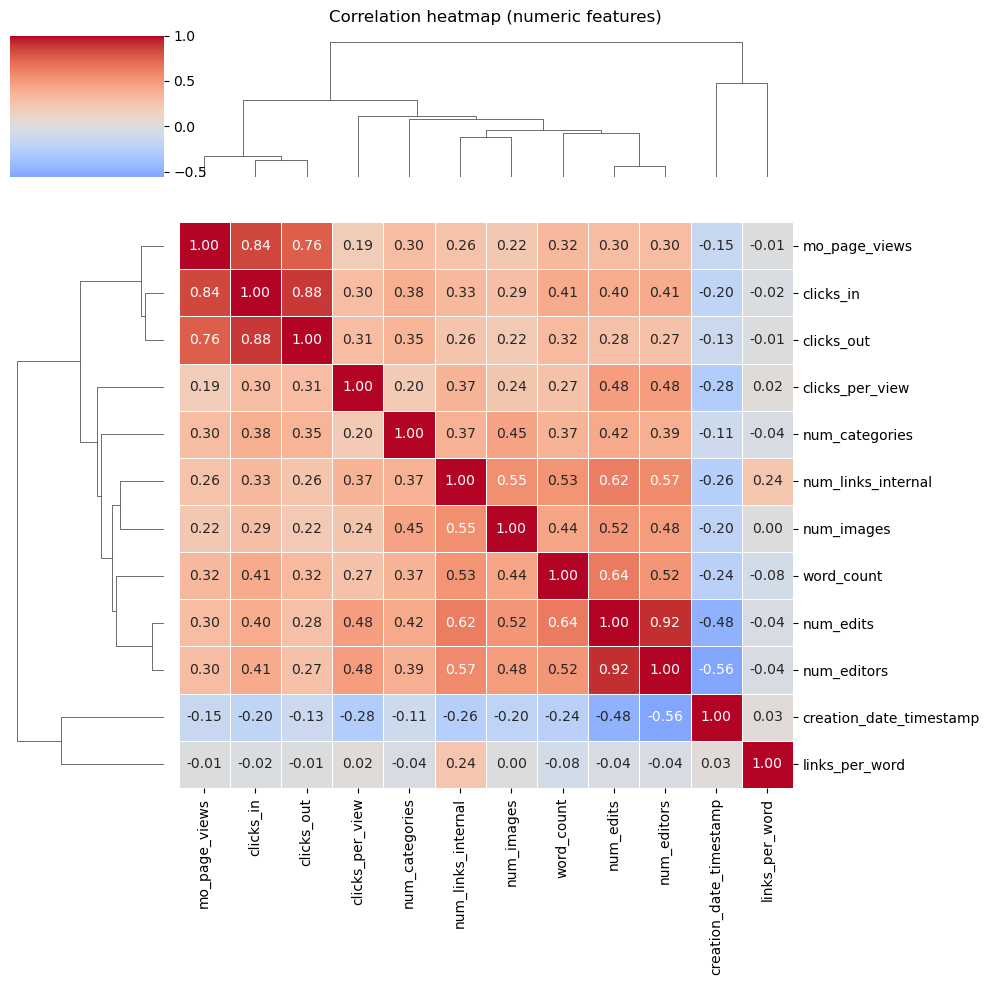

In [49]:
cols_log = [c for c in num_cols if c.startswith('log_')]
cols_lin = [c for c in num_cols if not c.startswith('log_')]

def draw_heatmap(cols_names):
  df_corr = df[cols_names].copy()
  df_corr = df_corr.astype(float)

  corr = df_corr.corr()

  g = sns.clustermap(
      corr,
      annot=True,
      cmap="coolwarm",
      center=0,
      fmt=".2f",
      linewidths=0.5
 #     figsize=(10, 10), 
 #     annot_kws={"size": 8}
  )

  g.fig.suptitle("Correlation heatmap (numeric features)")
  plt.tight_layout()
  plt.show()

draw_heatmap(cols_lin)

Widzimy, że większość zmiennych jest skorelowana ze sobą w sposób dodatni, ale przeważnie nie jest to silna korelacja. W oczy rzucają się silne korelacje między `mo_page_views`, `clicks_in` oraz `clicks_out` (co nie dziwi, gdyż jeśli na stronie jest dużo wyświetleń to siłą rzeczy było dużo przejść z innych stron oraz dużo kliknięć w linki na stronie), a takżę między `num_edits` oraz `num_editors` (jeśli było dużo edycji to przeważnie było dużo edytorów i w drugą stronę). Zauważyć należy słabą korelację `clicks_per_view` ze zmiennymi z których ona powstała. Warto też odnotować słabo ujemne korelacje (jako jedyne) zmiennej `creation_date_timestamp` oraz to, że `links_per_word` ma korelacje z większością zmiennych na poziomie 0. Dendrogram pokazuje 3 grupy zmiennych: statystyki dotyczące odwiedzin strony, statystyki dotyczące budowy artykułu oraz jego historii, oraz słabo zależne od innych data stworzenia i stosunek linków do słów.

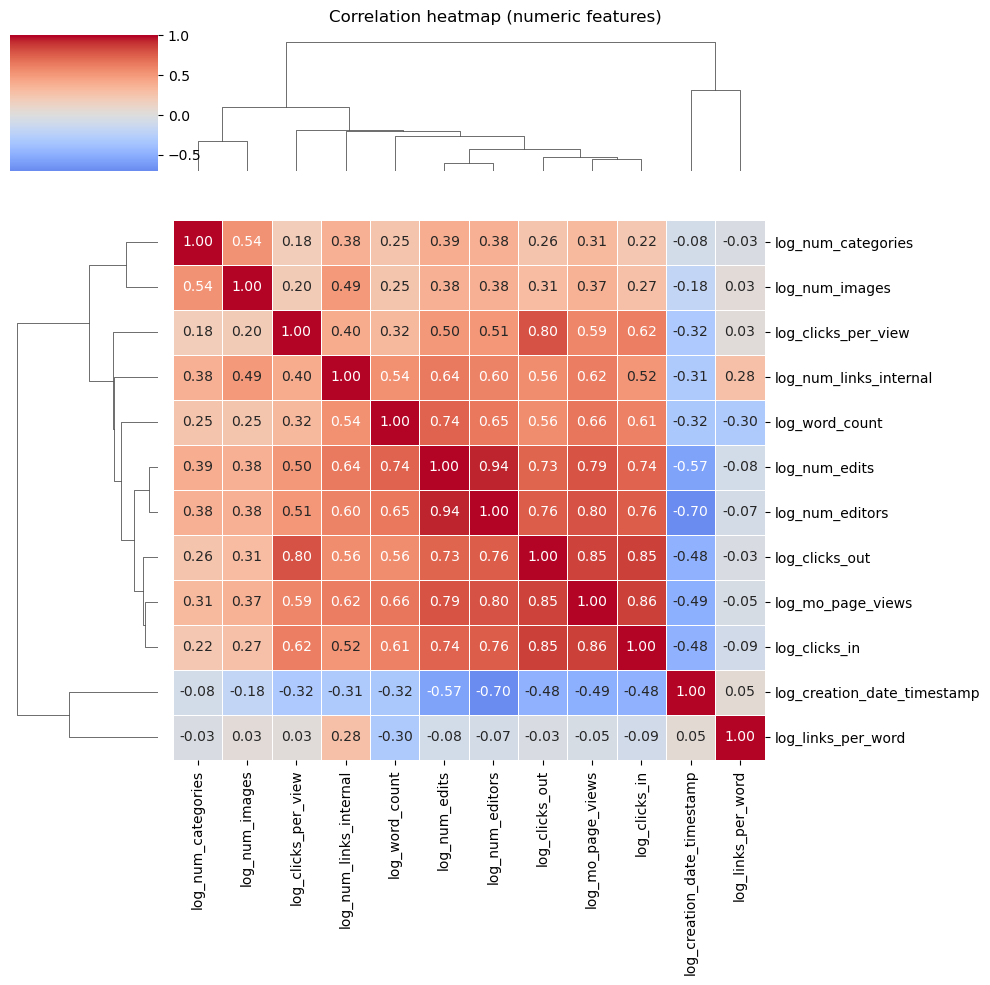

In [40]:
draw_heatmap(cols_log)

Korelacje między zmiennymi po zlogarytmowaniu rozkładają się zgrubsza podobnie, choć są pewne różnice. Przede wszystkim warto zauważyć, że na ogół korelacje są wyższe w porównaniu z niezlogarytmowaną wersją. Większość opisanych wcześniej trendów wzmocniła się po zlogarytmowaniu. Świadczyć to może, o nieliniowości danych. Potwierdzają się również wnioski z histogramów. Warto zauważyć, że tutaj jest już dużo większa korelacja między `clicks_per_view` oraz `clicks_out` (na poziomie 0.8). Co warte odnotowania to zmiany w dendrogramie. Ponownie statystyki aktywności są zgrupowane razem, ale potem najbliżej ich są statystyki dot. edycji. Ciekawe jest również zgrupowanie liczby kategorii oraz zdjęć. `Clicks_per_view` jest również znacznie "dalej" od statystyk aktywności, jest wręcz wymieszane w inne statystyki dot. budowy strony. Ogólnie, przy danych liniowych dało się wyróżnić trzy grupy, tak tutaj statystyki aktywności i budowy strony wymieszały się ze sobą tworząc jedną grupę.

In [59]:
cross_corr

,log_word_count,log_num_links_internal,log_num_categories,log_num_images,log_num_edits,log_num_editors,log_mo_page_views,log_clicks_in,log_clicks_out,log_clicks_per_view,log_creation_date_timestamp,log_links_per_word
word_count,0.754779,0.489039,0.301993,0.335843,0.563613,0.488480,0.556793,0.476304,0.474833,0.283681,-0.255552,-0.116816
num_links_internal,0.468488,0.896749,0.350384,0.479330,0.563375,0.531506,0.586992,0.472735,0.522688,0.380248,-0.278762,0.292677
num_categories,0.294195,0.356729,0.869107,0.438692,0.377157,0.366813,0.340878,0.256597,0.283154,0.209276,-0.120470,-0.042611
num_images,0.352187,0.543686,0.499389,0.938470,0.453134,0.435706,0.444315,0.342959,0.378523,0.254657,-0.214710,0.026531
num_edits,0.694231,0.636572,0.406733,0.437333,0.900308,0.852883,0.792181,0.698336,0.734516,0.506509,-0.505723,-0.062996
num_editors,0.612081,0.585797,0.379002,0.415126,0.833894,0.894611,0.795336,0.706137,0.744163,0.506175,-0.585931,-0.061719
mo_page_views,0.231391,0.213750,0.204113,0.177609,0.238689,0.244347,0.371601,0.285898,0.302297,0.196092,-0.159913,-0.018106
clicks_in,0.304025,0.270680,0.258935,0.231273,0.313401,0.323467,0.465936,0.391072,0.407151,0.305112,-0.214524,-0.033954
clicks_out,0.210898,0.199973,0.219285,0.169454,0.212327,0.215720,0.333516,0.271583,0.301360,0.298163,-0.139426,-0.015961
clicks_per_view,0.292077,0.377863,0.177613,0.195539,0.469884,0.482822,0.553814,0.582835,0.757812,0.995358,-0.294752,0.033992


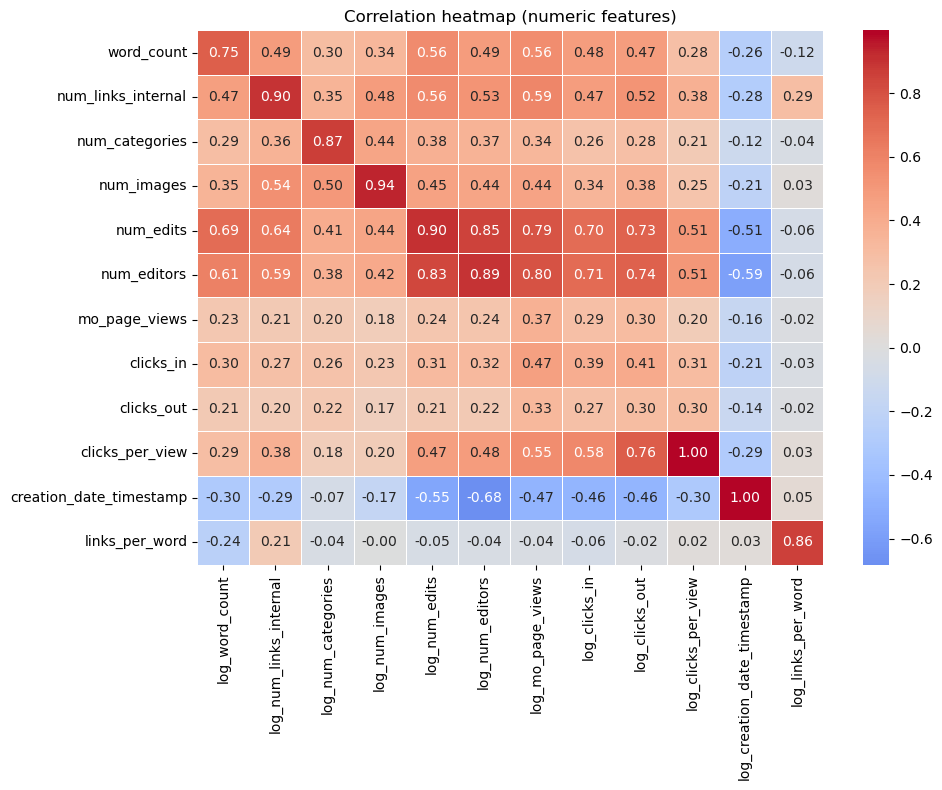

In [62]:
cross_corr = corr.loc[cols_lin, cols_log]

plt.figure(figsize=(10, 8))
sns.heatmap(
      cross_corr,
      annot=True,
      cmap="coolwarm",
      center=0,
      fmt=".2f",
      linewidths=0.5,
  )

plt.title("Correlation heatmap (numeric features)")
plt.tight_layout()
plt.show()

Korelacje są tutaj na podobnym poziomie co dla zmiennych liniowych. Ciekawe jest to, że niezlogarytmowane zmienne dot. edycji mają dużo wyższe korelacje ze zmiennymi zlogarytmowanymi, niż ich zlogarytmowane wersje. Na tej heatmapie już się niewyróżniają zmienne dot. aktywności na stronie. Ogólnie można odnieść wrażenie, że tutaj te korelacje są średnio mniejsze niż w poprzednich dwóch wersjach (poza anomalią ze zmiennymi dot. edycji). Ciekawe jest również to, że korelacja między wersjami zlogarytmowanymi, a niezlogarytmowanymi zmiennych dot. statystyk aktywności jest niska, rzędu 0.3-0.4. Wynika to najprawdopodobniej z ich sporej skośności.

## Znalezienie najpopularniejszych kategorii i dodanie kolumn im odpowiadających

In [85]:
categories = pd.Series([item for sublist in df["categories"] for item in sublist])

categories.value_counts()[:50]

articles with short description                          22900
short description is different from wikidata             12925
all stub articles                                         9687
short description matches wikidata                        9537
webarchive template wayback links                         3995
all articles with unsourced statements                    3641
all articles needing additional references                3510
articles with hcards                                      2664
living people                                             2312
fellows of the american mathematical society              1253
cs1 german-language sources (de)                          1251
all articles with dead external links                     1175
pages using gadget wikiminiatlas                          1132
commons category link is on wikidata                      1111
cs1 french-language sources (fr)                          1089
cs1 errors: isbn date                                  

In [87]:
categories

0         all wikipedia articles written in american eng...
1                     all articles with dead external links
2                     all articles with failed verification
3         articles containing ancient greek (to 1453)-la...
4                   articles containing greek-language text
                                ...                        
322821                                   geometric topology
322822                                       geometry stubs
322823                                         group theory
322824         short description is different from wikidata
322825                                             symmetry
Length: 322826, dtype: object

Jak widzimy, większość najpopularniejszych kategorii, to techniczne kategorie. Warto by było je odfiltrować

In [102]:
trash_words = [
    'articles', 'description', 'wikidata', 'stub', 'wayback', 
    'unsourced', 'references', 'hcards', 'cs1', 'cs2' 'links', 
    'gadget', 'infobox', 'citations', 'english', 'pages', 'missing', 'dmy'
]

pattern = "|".join(trash_words)

ranking = categories[~categories.str.contains(pattern)].value_counts()

print(len(ranking[ranking>50]))
ranking[:20]

256


living people                                   2312
fellows of the american mathematical society    1253
21st-century american mathematicians             795
20th-century american mathematicians             760
quantum mechanics                                323
condensed matter physics                         298
dynamical systems                                272
topology                                         256
nuclear physics                                  247
thermodynamics                                   243
mathematical physics                             233
physical quantities                              223
cryptography                                     213
number theory                                    213
mathematics-related lists                        211
pseudohistory                                    210
information theory                               201
astrophysics                                     199
mathematical logic                            

W top 20 oczyszczonych kategorii mamy zaledwie jedną (lub dwie, zależy jak liczyć "living_people") kategorie historyczne. Może lepiej będzie jak dorzucimy indykatory top 10 w każdym typie

In [107]:
df["type"].unique()

array(['mathematics', 'physics', 'history', 'history, mathematics',
       'mathematics, physics', 'history, physics'], dtype=object)

In [123]:
categories_rankings = {}
top_categories_rankings = {}

#top_categories = []

for i in ["mathematics", "physics", "history"]:
  categories = pd.Series([item for sublist in df[df["type"]==i]["categories"] for item in sublist])
  ranking = categories[~categories.str.contains(pattern)].value_counts()
  categories_rankings[i] = ranking
  top_categories_rankings[i] = ranking[:10]

top_categories = list(set(idx for s in top_categories_rankings.values() for idx in s.index))
top_categories

['mathematics-related lists',
 'archaeological artifacts',
 'number theory',
 'quantum mechanics',
 'dynamical systems',
 '20th-century american mathematicians',
 'measurement',
 'astrophysics',
 '21st-century american mathematicians',
 'pseudohistory',
 'creators of writing systems',
 'historiography',
 'historical eras',
 'thermodynamics',
 'nuclear physics',
 'death conspiracy theories',
 'topology',
 'cryptography',
 'philosophers of history',
 'mathematical logic',
 'condensed matter physics',
 'fellows of the american physical society',
 'physical quantities',
 'living people',
 'mechanics',
 'destroyed populated places',
 'pseudohistorians',
 'fellows of the american mathematical society']

In [ ]:
for i in top_categories:
    clean_name = f"cat_{i.replace(' ', '_').replace('-', '_')}"
    df[clean_name] = df['categories'].apply(lambda x: 1 if i in x else 0)

,title,word_count,num_links_internal,num_categories,categories,num_images,image_titles,num_edits,num_editors,summary,...,cat_philosophers_of_history,cat_mathematical_logic,cat_condensed_matter_physics,cat_fellows_of_the_american_physical_society,cat_physical_quantities,cat_living_people,cat_mechanics,cat_destroyed_populated_places,cat_pseudohistorians,cat_fellows_of_the_american_mathematical_society
0,mathematics,8055,500,24,[all wikipedia articles written in american en...,10,"[arithmetic symbols.svg, bakhshali numerals 2....",500,284,mathematics is a field of study that discovers...,...,0,0,0,0,0,0,0,0,0,0
1,language of mathematics,797,83,6,"[all articles needing additional references, a...",1,[question book-new.svg],308,170,the language of mathematics or mathematical la...,...,0,0,0,0,0,0,0,0,0,0
2,abacus,3991,235,33,"[abacus, all wikipedia articles written in ame...",10,"[1543 robert recorde.png, abacus (psf).png, ab...",500,279,"an abacus (pl. abaci or abacuses), also called...",...,0,0,0,0,0,0,0,0,0,0
3,roman abacus,2018,92,11,"[abacus, all articles that may contain origina...",8,"[abacus usages.jpg, ambox important.svg, commo...",339,158,the ancient romans developed the roman hand ab...,...,0,0,0,0,0,0,0,0,0,0
4,tlalcuahuitl,152,11,5,"[articles with short description, aztec mathem...",5,[cemacolli one third tlalcuahuitl aztec glyph....,52,9,tlalcuahuitl [t͡ɬaɬˈkʷawit͡ɬ] or land rod also...,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29385,wykeham professor,285,33,11,[all wikipedia articles written in british eng...,1,[question book-new.svg],98,54,the university of oxford has three statutory p...,...,0,0,0,0,0,0,0,0,0,0
29386,yang–mills equations,3464,117,6,"[articles with short description, differential...",4,"[-y-(x^2+y^2+1) plot; bpst instanton.png, bpst...",83,32,"in physics and mathematics, and especially dif...",...,0,0,0,0,0,0,0,0,0,0
29387,zeitschrift für angewandte mathematik und physik,74,31,15,"[academic journals established in 1950, all st...",4,"[book hexagonal icon.svg, e-to-the-i-pi.svg, l...",44,30,the zeitschrift für angewandte mathematik und ...,...,0,0,0,0,0,0,0,0,0,0
29388,zero-point energy,17152,500,31,"[all accuracy disputes, all articles with unso...",10,"[2 helium.png, albert einstein (nobel).png, cm...",500,280,zero-point energy (zpe) is the lowest possible...,...,0,0,1,0,0,0,0,0,0,0


In [130]:
print(df["summary"].isna().sum())
print(df["title"].isna().sum())

0
0


## Dodanie indykatorów dla `mo_page_views`, `clicks_in`, `clicks_out` oraz `clicks_per_view`

In [131]:
for i in ["mo_page_views", "clicks_in", "clicks_out", "clicks_per_view"]:
  df[f"is_{i}_zero"] = df[i]==0

## Posortowanie kolumn

In [134]:
df.columns

Index(['title', 'word_count', 'num_links_internal', 'num_categories',
       'categories', 'num_images', 'image_titles', 'num_edits', 'num_editors',
       'summary', 'creation_date', 'mo_page_views', 'clicks_in', 'clicks_out',
       'clicks_per_view', 'type', 'categories_string', 'image_titles_string',
       'creation_date_timestamp', 'links_per_word', 'log_word_count',
       'log_num_links_internal', 'log_num_categories', 'log_num_images',
       'log_num_edits', 'log_num_editors', 'log_mo_page_views',
       'log_clicks_in', 'log_clicks_out', 'log_clicks_per_view',
       'log_creation_date_timestamp', 'log_links_per_word',
       'cat_mathematics_related_lists', 'cat_archaeological_artifacts',
       'cat_number_theory', 'cat_quantum_mechanics', 'cat_dynamical_systems',
       'cat_20th_century_american_mathematicians', 'cat_measurement',
       'cat_astrophysics', 'cat_21st_century_american_mathematicians',
       'cat_pseudohistory', 'cat_creators_of_writing_systems',
       '

In [136]:
zmienne_okolotekstowe = ['title', 'summary', 'word_count', 'log_word_count']
obrazy = ['image_titles', 'image_titles_string', 'num_images', 'log_num_images']
statystyki_wizyt = ['mo_page_views', 'log_mo_page_views', 'clicks_in', 'log_clicks_in', 'clicks_out', 'log_clicks_out', 'clicks_per_view', 'log_clicks_per_view']
indykatory_statystyk_wizyt = ['is_mo_page_views_zero', 'is_clicks_in_zero', 'is_clicks_out_zero',
       'is_clicks_per_view_zero']
typ = ['type']
kategorie = ["categories", 'categories_string', 'num_categories', 'log_num_categories']
pozostale_statystyki = ['num_links_internal', 'log_num_links_internal', 'num_editors', 'log_num_editors', 'num_edits', 'log_num_edits', 'creation_date', 'creation_date_timestamp', 'log_creation_date_timestamp', 'links_per_word', 'log_links_per_word']
indykatory_kategorii = ['cat_mathematics_related_lists', 'cat_archaeological_artifacts', 'cat_number_theory', 'cat_quantum_mechanics', 'cat_dynamical_systems', 'cat_20th_century_american_mathematicians', 'cat_measurement', 'cat_astrophysics', 'cat_21st_century_american_mathematicians', 'cat_pseudohistory', 'cat_creators_of_writing_systems', 'cat_historiography', 'cat_historical_eras', 'cat_thermodynamics', 'cat_nuclear_physics', 'cat_death_conspiracy_theories', 'cat_topology', 'cat_cryptography', 'cat_philosophers_of_history', 'cat_mathematical_logic', 'cat_condensed_matter_physics', 'cat_fellows_of_the_american_physical_society', 'cat_physical_quantities', 'cat_living_people', 'cat_mechanics', 'cat_destroyed_populated_places', 'cat_pseudohistorians', 'cat_fellows_of_the_american_mathematical_society',]

nazwy = zmienne_okolotekstowe + obrazy + statystyki_wizyt + indykatory_statystyk_wizyt + typ + kategorie + pozostale_statystyki + indykatory_kategorii
df = df[nazwy]

In [138]:
path = "data//wikipedia.csv"
df.to_csv(path)